In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from IPython import display
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
%matplotlib inline

В качестве примера работы алгоритма и простоты воспроизводимости будем использовать MNIST. Однако данный алгоритм способен работать с любыми изображениями для классификации, при изменении во входных каналах нейронной сети.

In [2]:
num_classes = 10

In [3]:
# Загрузим датасет MNIST
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()

# Переведем значения пикселей в диапазон [0, 1] и добавим размерность канала
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)

print(X_train.shape)
print(X_test.shape)

# Преобразуем метки в one-hot encoding
y_train_one_hot = keras.utils.to_categorical(y_train, num_classes=num_classes)
y_test_one_hot = keras.utils.to_categorical(y_test, num_classes=num_classes)
print(y_test_one_hot.shape)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train_one_hot, test_size=0.2, random_state=42)
print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)
(10000, 10)
(48000, 28, 28, 1)
(12000, 28, 28, 1)
(48000, 10)
(12000, 10)


Используем простую модель для симулирования плохих результатов изначального обучения, можно и ограничить обучающую выборку с более хорошей моделью. Так же можно использовать любую модель и в том числе предобученную.

In [4]:
model = keras.Sequential([
    layers.Input(shape=(28, 28, 1)),
    # layers.Conv2D(32, (3, 3), activation='relu'),
    # layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(2, activation='linear'),
    layers.Dense(num_classes, activation='softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 2)                 1570      
                                                                 
 dense_1 (Dense)             (None, 10)                30        
                                                                 
Total params: 1600 (6.25 KB)
Trainable params: 1600 (6.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [5]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [6]:
# Начальное обучение модели
initial_epochs = 1
model.fit(X_train, y_train, epochs=initial_epochs)

# Оценка модели на тестовой выборке
test_loss, test_acc = model.evaluate(X_test, y_test_one_hot)
print(f'Точность на тестовой выборке: {test_acc}')

313/313 [==============================] - 1s 2ms/step - loss: 1.0895 - accuracy: 0.6346
Точность на тестовой выборке: 0.6345999836921692


In [7]:
# Определение функции для дополнительной разметки данных
def annotate_images(images, model, threshold=0.5):
    # Используем модель для предсказания меток
    predictions = model.predict(images)

    # Выбираем индексы изображений,
    uncertain_samples_tresh = np.where(np.max(predictions, axis=1) < threshold)[0]

    for idx in uncertain_samples_tresh:
        # print(idx)
        predicted_class = np.argmax(predictions[idx])
        if predictions[idx, predicted_class] <= threshold:
            plt.imshow(images[idx], cmap='gray')
            plt.title(f"Предсказанный класс: {predicted_class} , Вероятность предсказания: {predictions[idx, predicted_class]}")
            plt.show()

            # Ввод пользовательской метки
            print('Веведите метку класса')
            user_label = input()

            # Запись метки в predictions
            predictions[idx] = 0
            predictions[idx, int(user_label)] = 1

    return uncertain_samples_tresh, predictions[uncertain_samples_tresh]

(5, 28, 28, 1) (5, 10)

Активное обучение: итерация 1
1/1 [==============================] - 0s 330ms/step


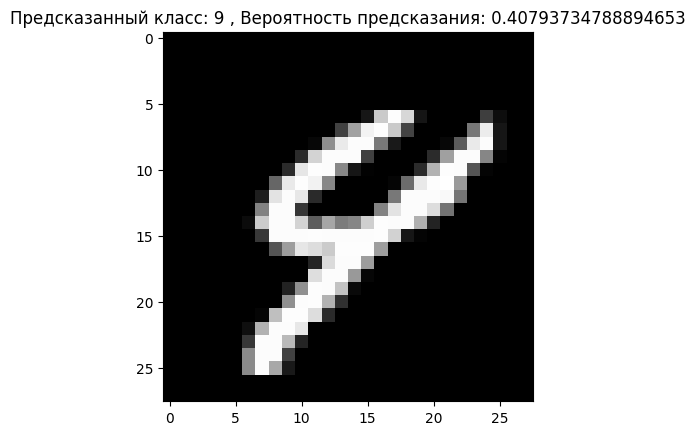

Веведите метку класса
4


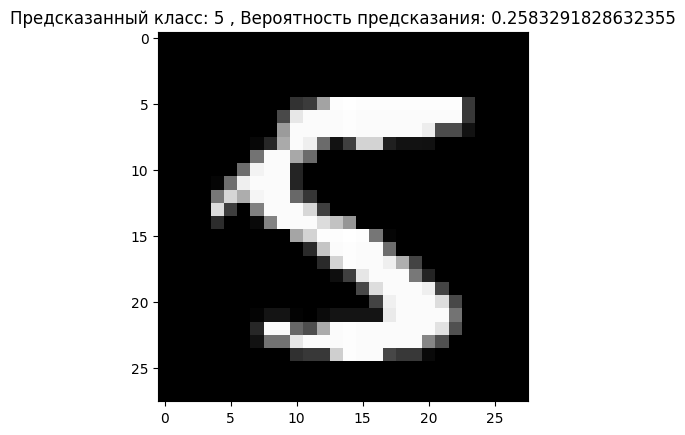

Веведите метку класса
5


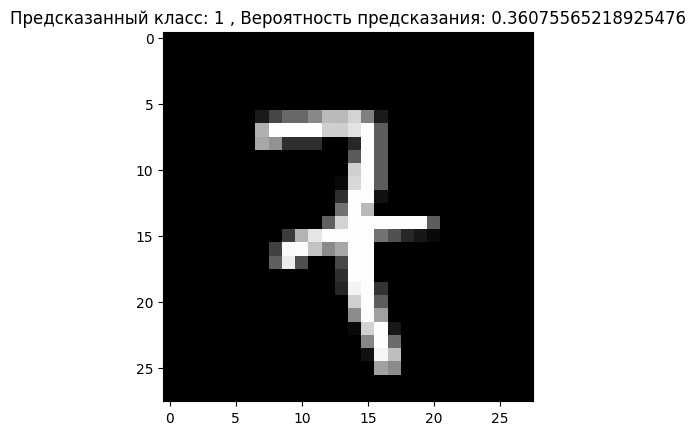

Веведите метку класса
7
313/313 [==============================] - 0s 1ms/step - loss: 0.9939 - accuracy: 0.6733

Точность на тестовой выборке после активного обучения: 0.67330002784729


In [8]:
# Активное обучение
num_active_learning_iterations = 1
num_samples = 5

for iteration in range(num_active_learning_iterations):
    selected_indices = np.random.choice(len(X_val), size=num_samples, replace=False)
    selected_values = X_val[selected_indices]
    selected_labels = y_val[selected_indices]
    print(selected_values.shape, selected_labels.shape)
    print(f"\nАктивное обучение: итерация {iteration + 1}")

    # Получение индексов изображений, которые модель наименее уверенно классифицирует
    uncertain_indices, predictions = annotate_images(selected_values, model)

    # Добавление дополнительных данных в обучающий набор
    X_train = np.concatenate([X_train, selected_values[uncertain_indices]])
    y_train = np.concatenate([y_train, keras.utils.to_categorical(np.argmax(predictions, axis=1), num_classes=num_classes)])

    # Удаление добавленных данных из валидационного набора
    X_val = np.delete(X_val, selected_indices, axis=0)
    y_val = np.delete(y_val, selected_indices, axis=0)

    # Перемешивание данных
    X_train, y_train = shuffle(X_train, y_train, random_state=2023)
    X_val, y_val = shuffle(X_val, y_val, random_state=2023)

    # Повторное обучение модели с новыми данными
    model.fit(X_train, y_train, epochs=1, validation_data=(X_val, y_val))

# Оценка окончательной модели на тестовой выборке
test_loss, test_acc = model.evaluate(X_test, y_test_one_hot)
print(f'\nТочность на тестовой выборке после активного обучения: {test_acc}')

После одной итерации алгоритма точность увеличилась с 0.63 до 0.67